In [1]:
import sklearn
from sklearn.decomposition import PCA
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_recall_fscore_support, precision_score, recall_score, confusion_matrix, matthews_corrcoef


In [2]:
#import 2d Descriptor data
descriptor_features = pd.read_csv('/Users/matthewholland/OneDrive/Oxford/Amide Bond Formation/Features/scaled_lasso_features.csv', index_col=0)
descriptor_features = descriptor_features.drop('Unnamed: 0.1', axis=1)
labels = pd.read_csv('/Users/matthewholland/OneDrive/Oxford/Amide Bond Formation/Features/training_labels_unscaled.csv', index_col=0)
descriptor_features = descriptor_features.set_index(labels.index)

#import DFT data
dft_descriptors = pd.read_csv('/Users/matthewholland/OneDrive/Oxford/Amide Bond Formation/Features/dft_training_features.csv', index_col=0)

#import random data
random_data = pd.read_csv('/Users/matthewholland/OneDrive/Oxford/Amide Bond Formation/Features/random_features/random_features.csv', index_col=0)
random_features = random_data.drop(['Yield /%'], axis=1)

In [3]:
#Add yields (labels) to features dataframes to group by yield
descriptor_data = pd.concat([descriptor_features, labels], axis=1, join='inner')
dft_data = pd.concat([dft_descriptors,labels], axis=1, join='inner')


In [4]:
#Classify the data according to yield (0='bad', 1='good')
for dataset in [descriptor_data, dft_data, random_data]:
    dataset['yield_category'] = pd.cut(dataset['Yield /%'], bins = [0, 50, 100], right=True, labels=[0, 1], include_lowest=True)
    

In [5]:
#Remove yield labels
descriptor_categorical = descriptor_data.drop('Yield /%', axis=1)
dft_categorical = dft_data.drop('Yield /%', axis=1)
random_categorical = dft_data.drop('Yield /%', axis=1)

In [6]:
classifiers = {
    'SGD' : SGDClassifier(random_state=42),
    'Logistic Regression' : LogisticRegression(),
    'Random Forest' : RandomForestClassifier(random_state=42),
    'Linear SVM' : SVC(kernel='linear', C=1),
    'Quadratic SVM' : SVC(kernel='poly', degree=2),
    'Cubic SVM' : SVC(kernel='poly', degree=3), 
    'Quartic SVM' : SVC(kernel='poly', degree=4),
    'Quintic SVM' : SVC(kernel='poly', degree=5),
    'Gaussian SVM' : SVC(kernel='rbf'),
    'Decision Tree' : DecisionTreeClassifier(max_depth=2),
    'GBoost' : GradientBoostingClassifier(random_state=42),
    'XGBoost' : XGBClassifier(verbosity=0,random_state=42),
    'MLPC Classifier' : MLPClassifier(alpha=1, max_iter=1000), 
    'kNN' : KNeighborsClassifier(),
    'Gaussian Naive Bayes' : GaussianNB()
}

In [7]:
def run_classifiers(classifiers, training_features, training_labels):
    f1_scores = {}
    predicted = {}
    precision_recall = {}
    matthews_coeffs = {}
    for key, classifier in classifiers.items():
        model = classifier
        model.fit(training_features, training_labels)
        train_predict = cross_val_predict(model, training_features, training_labels, cv=5)
        predicted[key] = train_predict.tolist()
        f1 = f1_score(training_labels, train_predict)
        f1_scores[key] = f1
        precision_recall[key] = confusion_matrix(training_labels, train_predict).ravel().tolist()
        matthews_coeffs[key] = matthews_corrcoef(training_labels, train_predict)
    return f1_scores, predicted, precision_recall, matthews_coeffs

In [8]:
#Train classifiers on the feature sets
descriptor_f1, descriptor_predictions, descriptor_precision_recall, descriptor_matthews = run_classifiers(classifiers, descriptor_features, descriptor_categorical['yield_category'])
dft_f1, dft_predictions, dft_precision_recall, dft_matthews = run_classifiers(classifiers, dft_descriptors, descriptor_categorical['yield_category'])
random_f1, random_predictions, random_precision_recall, random_matthews = run_classifiers(classifiers, random_features, descriptor_categorical['yield_category'])

/opt/anaconda3/envs/boronic_acid/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/boronic_acid/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/boronic_acid/lib/python3.9/site-packag

In [9]:
def plot_classification_results(ax, precision_recall_dictionary, title):
    ax.plot([0, 0.6], [0, 0.6], '-', color='black', linewidth=2)
    markers=['s', 's', 's', 's', 's', 's', 's', 'v', 'v','v','v','v','v','v','d']
    colours=['r', 'g', 'b', 'c', 'm', 'y', 'k', 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'r']
    marker = 0
    for key, value in precision_recall_dictionary.items():
        false_positive = value[1] / sum(value)
        true_positive = value[3] / sum(value)
        ax.plot(false_positive, true_positive, marker = markers[marker], color=colours[marker], label=key, markersize=10)
        marker += 1

    # Set tick font size
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
	    label.set_fontsize(20)
    ax.set_xlim([0, 0.5])
    ax.set_ylim([0, 0.6])
    #ax.get_xaxis().tick_bottom()
    #ax.get_yaxis().tick_left()
    ax.set_aspect('equal')
    ax.spines['left'].set_position(('outward',10))
    ax.spines['bottom'].set_position(('outward', 10))
    ax.set_xlabel('False Positive Rate', fontsize=16)
    ax.set_ylabel('False Negative Rate', fontsize=16)
    #ax.legend(loc='lower right')
    title = title
    ax.set_title(title, fontsize=18)


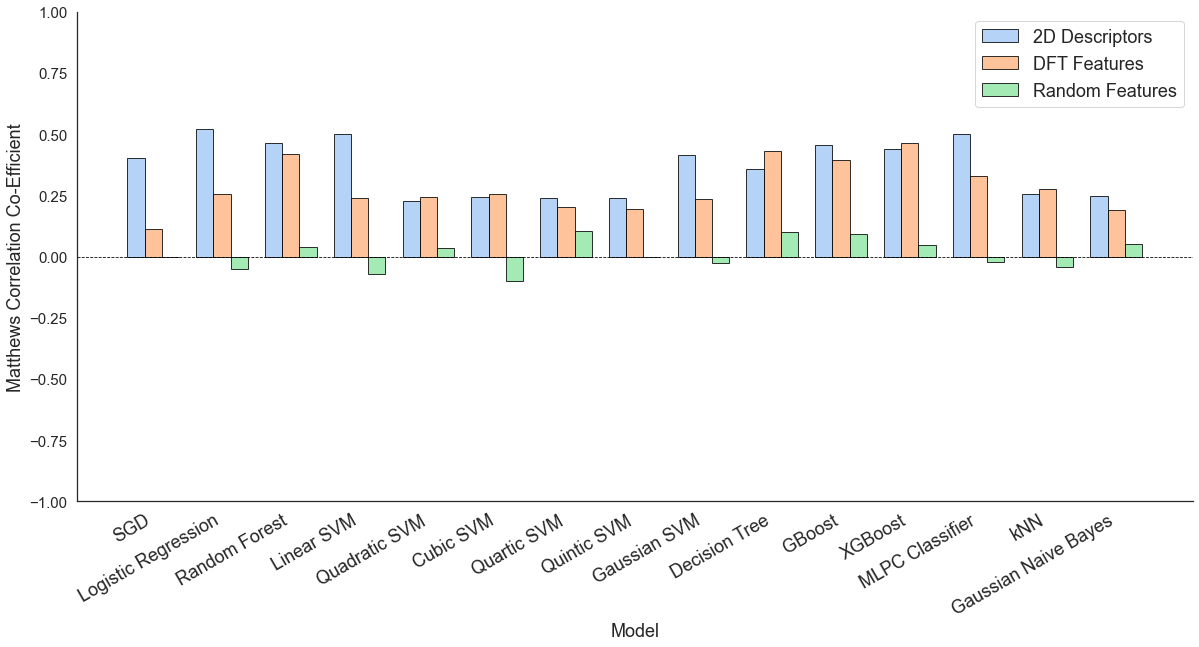

In [25]:
sns.set()
sns.set_palette('pastel')
sns.set_style(style='white')
fig= plt.figure(figsize=(20,10))
ax=plt.axes()
index = np.arange(0, 30, 2)
bar_width = 0.5
opacity = 0.8

descriptor_bar = plt.bar(index, list(descriptor_matthews.values()), bar_width, alpha=opacity, label='2D Descriptors', align='edge', edgecolor='black')

dft_bar = plt.bar(index + bar_width, list(dft_matthews.values()), bar_width, alpha=opacity, label='DFT Features', align='edge', edgecolor='black')

random_bar = plt.bar(index + 2*bar_width, list(random_matthews.values()), bar_width, alpha=opacity, label='Random Features', align='edge', edgecolor='black')


plt.xlabel('Model', fontsize=18)
plt.ylabel('Matthews Correlation Co-Efficient', fontsize=18)
#plt.title('Matthews Correlation Scores for Binary Classification Algorithms', fontsize=22)
plt.xticks(index+1.5*bar_width, list(random_matthews.keys()), fontsize=18)
fig.autofmt_xdate()
plt.yticks(fontsize=15)
plt.ylim((-1, 1))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.legend(prop={'size':18})
plt.savefig('/Users/matthewholland/OneDrive/Oxford/Amide Bond Formation/Visualisation/Figures/matthews_correlation_binary.png', dpi=1500, bbox_inches='tight', pad_inches=0)
plt.show()

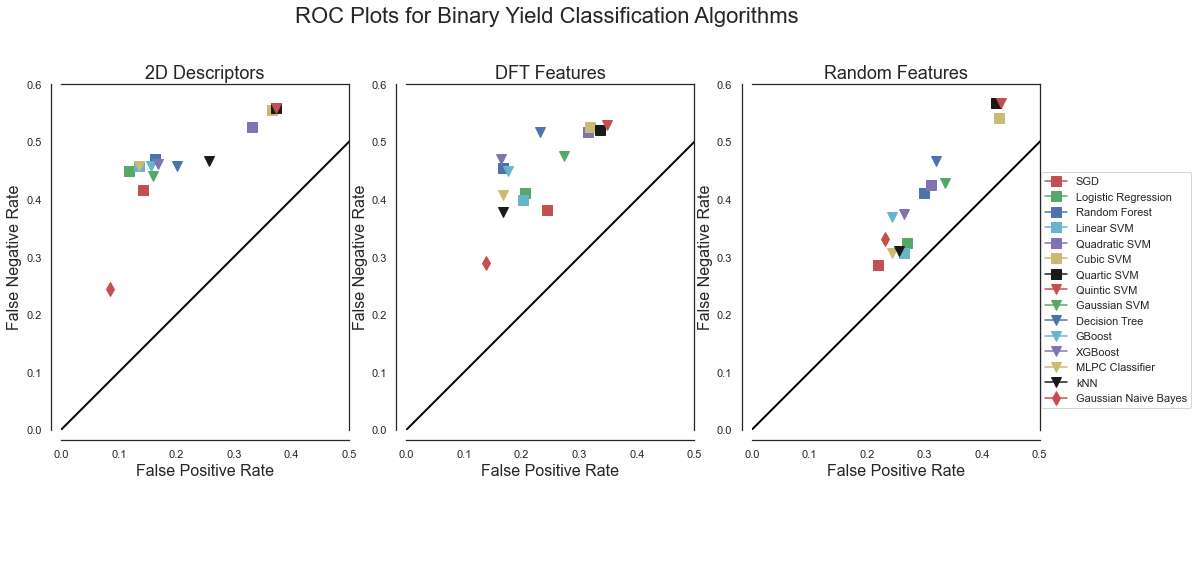

In [11]:
fig = plt.figure(figsize=(18,13))
#fig.subplots_adjust(hspace=0.2, wspace=0.2)
ax = fig.add_subplot(1,3,1)
plot_classification_results(ax, descriptor_precision_recall, '2D Descriptors')
ax = fig.add_subplot(1,3,2)
plot_classification_results(ax, dft_precision_recall, 'DFT Features')
ax = fig.add_subplot(1,3, 3)
plot_classification_results(ax, random_precision_recall, 'Random Features')
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='right')
plt.subplots_adjust(right=0.88, top=1.3)
plt.suptitle('ROC Plots for Binary Yield Classification Algorithms', fontsize=22)
plt.savefig('/Users/matthewholland/OneDrive/Oxford/Amide Bond Formation/Visualisation/Figures/binary_classifier.png', transparent=True, bbox_inches='tight')
plt.show()


Now attempt the same, only bucketing into bins of 25%, rather than two bins of 50%

In [12]:
#Classify the data according to yield (0 = [0, 25], 1 = (25, 50], 2 = (50, 75], 3 = (75, 100])
for dataset in [descriptor_data, dft_data, random_data]:
    dataset['yield_category'] = pd.cut(dataset['Yield /%'], bins = [0, 25, 50,75, 100], right=True, labels=[0, 1, 2, 3], include_lowest=True)

In [13]:
multiclass_models = {
    'SGD' : SGDClassifier(random_state=42),
    'Logistic Regression' : LogisticRegression(multi_class='multinomial'),
    'Random Forest' : RandomForestClassifier(random_state=42),
    'Linear SVM' : SVC(kernel='linear', C=1),
    'Quadratic SVM' : SVC(kernel='poly', degree=2),
    'Cubic SVM' : SVC(kernel='poly', degree=3), 
    'Quartic SVM' : SVC(kernel='poly', degree=4),
    'Quintic SVM' : SVC(kernel='poly', degree=5),
    'Gaussian SVM' : SVC(kernel='rbf'),
    'Decision Tree' : DecisionTreeClassifier(max_depth=2),
    'GBoost' : GradientBoostingClassifier(random_state=42),
    'XGBoost' : XGBClassifier(verbosity=0,random_state=42, use_label_encoder=False),
    'MLPC Classifier' : MLPClassifier(alpha=1, max_iter=1000), 
    'kNN' : KNeighborsClassifier(),
    'Gaussian Naive Bayes' : GaussianNB()
}

def run_multiclass_classifiers(classifiers, training_features, training_labels):
    matthews_corrcoeffs = {}
    predicted = {}
    precision_recall = {}
    for key, classifier in classifiers.items():
        model = classifier
        model.fit(training_features, training_labels)
        train_predict = cross_val_predict(model, training_features, training_labels, cv=5)
        predicted[key] = train_predict.tolist()
        matthews = matthews_corrcoef(training_labels, train_predict)
        matthews_corrcoeffs[key] = matthews
        precision_recall[key] = confusion_matrix(training_labels, train_predict).ravel().tolist()
    return matthews_corrcoeffs, predicted, precision_recall

In [14]:
descriptor_multi_matthews, descriptor_multi_predictions, descriptor_multi_precision_recall = run_multiclass_classifiers(classifiers, descriptor_features, descriptor_data['yield_category'])
dft_multi_matthews, dft_multi_predictions, dft_multi_precision_recall = run_multiclass_classifiers(classifiers, dft_descriptors, descriptor_data['yield_category'])
random_multi_matthews, random_multi_predictions, random_multi_precision_recall = run_multiclass_classifiers(classifiers, random_features, descriptor_data['yield_category'])

/opt/anaconda3/envs/boronic_acid/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/boronic_acid/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/boronic_acid/lib/python3.9/site-packag

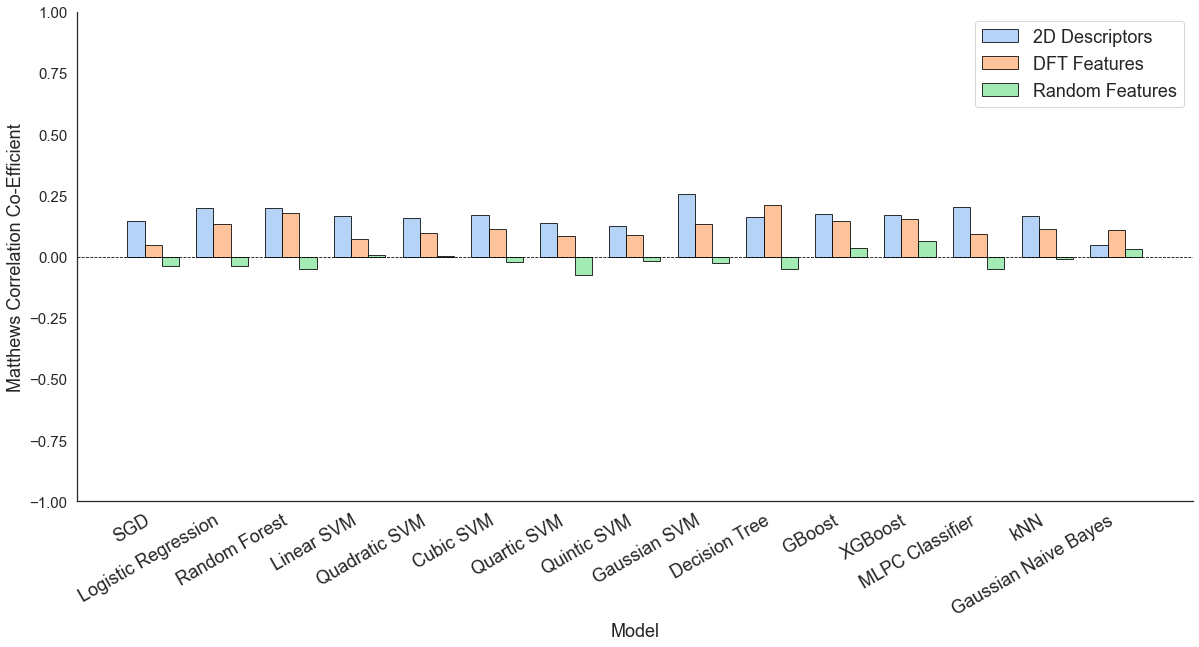

In [24]:
sns.set()
sns.set_palette('pastel')
sns.set_style(style='white')
fig= plt.figure(figsize=(20,10))
ax=plt.axes()
index = np.arange(0, 30, 2)
bar_width = 0.5
opacity = 0.8

descriptor_bar = plt.bar(index, list(descriptor_multi_matthews.values()), bar_width, alpha=opacity, label='2D Descriptors', align='edge', edgecolor='black')

dft_bar = plt.bar(index + bar_width, list(dft_multi_matthews.values()), bar_width, alpha=opacity, label='DFT Features', align='edge', edgecolor='black')

random_bar = plt.bar(index + 2*bar_width, list(random_multi_matthews.values()), bar_width, alpha=opacity, label='Random Features', align='edge', edgecolor='black')


plt.xlabel('Model', fontsize=18)
plt.ylabel('Matthews Correlation Co-Efficient', fontsize=18)
#plt.title('Matthews Correlation Scores for 4 Class Classification Algorithms', fontsize=22)
plt.xticks(index+1.5*bar_width, list(random_multi_matthews.keys()), fontsize=18)
fig.autofmt_xdate()
plt.yticks(fontsize=15)
plt.ylim((-1, 1))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.legend(prop={'size':18})
#plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.savefig('/Users/matthewholland/OneDrive/Oxford/Amide Bond Formation/Visualisation/Figures/matthews_correlation_4_class.png', dpi=1500, bbox_inches='tight', pad_inches=0)
plt.show()